In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'cubehelix'
plt.rcParams['image.origin'] = 'lower'

In [2]:
from sherpa.astro import ui
from sherpa.models import Gauss2D
from sherpa.astro.data import Data2D
import numpy as np
import corner

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [3]:
np.random.seed(4)
x0lo, x0hi = 3000, 4000
x1lo, x1hi = 4000, 4800
dx = 5
x1, x0 = np.mgrid[x1lo:x1hi:dx, x0lo:x0hi:dx]
shape = x0.shape
x0 = x0.flatten()
x1 = x1.flatten()

fwhm2sigma = 2.35482004503

source_one = Gauss2D('src1')
source_one.xpos = 3561
source_one.ypos = 4482
source_one.ampl = 35
source_one.fwhm = fwhm2sigma*50

source_two = Gauss2D('src2')
source_two.xpos = 3561
source_two.ypos = 4482
source_two.ampl = 10
source_two.fwhm = fwhm2sigma*150

source = source_one + source_two

mexp = source(x0, x1).reshape(shape)
image = np.random.poisson(mexp)

ui.load_arrays(1, x0, x1, image.flatten(), Data2D)

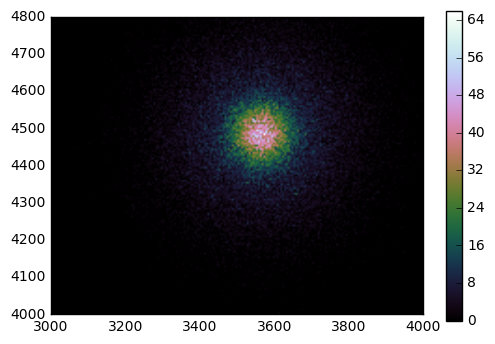

In [4]:
boundaries = (x0lo, x0hi, x1lo, x1hi)
plt.imshow(image, extent=boundaries)
plt.colorbar()

In [5]:
model_one = Gauss2D('model_one')
model_two = Gauss2D('model_two')
model = model_one + model_two
ui.set_model(model)
ui.guess(model_one)
ui.guess(model_two)
peak = image.max()
model_one.ampl = peak
model_two.ampl = peak/10
model_one.fwhm = 100
model_one.fwhm = 200

In [6]:
ui.set_method('neldermead')
ui.set_stat('cash')
ui.fit()
residuals = image - model(x0, x1).reshape(shape)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -67050.7
Final fit statistic   = -161745 at function evaluation 1975
Data points           = 32000
Degrees of freedom    = 31992
Change in statistic   = 94694.5
   model_one.fwhm   354         
   model_one.xpos   3561.27     
   model_one.ypos   4482.27     
   model_one.ampl   9.96813     
   model_two.fwhm   117.062     
   model_two.xpos   3561.46     
   model_two.ypos   4481.46     
   model_two.ampl   35.3615     


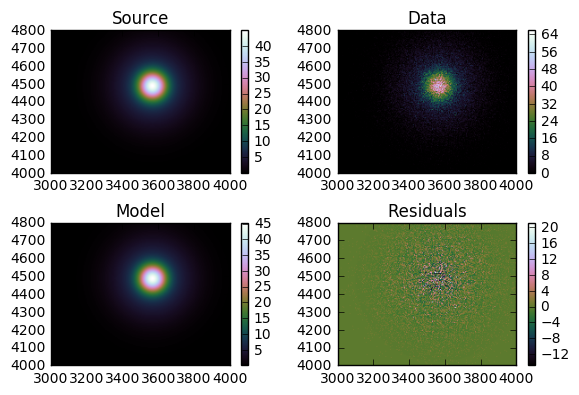

In [7]:
plt.subplot(2, 2, 1)
plt.imshow(mexp, extent=boundaries)
plt.colorbar()
plt.title('Source')

plt.subplot(2, 2, 2)
plt.imshow(image, extent=boundaries)
plt.colorbar()
plt.title('Data')

plt.subplot(2, 2, 3)
plt.imshow(model(x0, x1).reshape(shape), extent=boundaries)
plt.colorbar()
plt.title('Model')

plt.subplot(2, 2, 4)
plt.imshow(residuals, extent=boundaries)
plt.colorbar()
plt.title('Residuals')
plt.tight_layout()

In [8]:
residuals.sum()

-6.5222545728715886e-06

In [9]:
ui.covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   model_one.fwhm          354     -1.12982      1.12982
   model_one.xpos      3561.27    -0.665661     0.665661
   model_one.ypos      4482.27    -0.706617     0.706617
   model_one.ampl      9.96813    -0.105591     0.105591
   model_two.fwhm      117.062      -0.9727       0.9727
   model_two.xpos      3561.46    -0.529633     0.529633
   model_two.ypos      4481.46     -0.52919      0.52919
   model_two.ampl      35.3615    -0.454002     0.454002


In [10]:
stats, accept, params = ui.get_draws(1, niter=10000)

Using Priors:
model_one.fwhm: <function flat at 0x7efe5b58cc80>
model_one.xpos: <function flat at 0x7efe5b58cc80>
model_one.ypos: <function flat at 0x7efe5b58cc80>
model_one.ampl: <function flat at 0x7efe5b58cc80>
model_two.fwhm: <function flat at 0x7efe5b58cc80>
model_two.xpos: <function flat at 0x7efe5b58cc80>
model_two.ypos: <function flat at 0x7efe5b58cc80>
model_two.ampl: <function flat at 0x7efe5b58cc80>


In [11]:
print(source, "\n\n", model)

(src1 + src2)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   src1.fwhm    thawed      117.741  1.17549e-38  3.40282e+38           
   src1.xpos    thawed         3561 -3.40282e+38  3.40282e+38           
   src1.ypos    thawed         4482 -3.40282e+38  3.40282e+38           
   src1.ellip   frozen            0            0        0.999           
   src1.theta   frozen            0     -6.28319      6.28319    radians
   src1.ampl    thawed           35 -3.40282e+38  3.40282e+38           
   src2.fwhm    thawed      353.223  1.17549e-38  3.40282e+38           
   src2.xpos    thawed         3561 -3.40282e+38  3.40282e+38           
   src2.ypos    thawed         4482 -3.40282e+38  3.40282e+38           
   src2.ellip   frozen            0            0        0.999           
   src2.theta   frozen            0     -6.28319      6.28319    radians
   src2.ampl    thawed           10 -

In [12]:
parnames = [p.fullname for p in model.pars if not p.frozen]
mapping = [p.replace('model_one', 'src2') for p in parnames]
mapping = [p.replace('model_two', 'src1') for p in mapping]
parvals = [getattr(source_one, parname.split('.')[-1]).val
           if 'src1' in parname
           else getattr(source_two, parname.split('.')[-1]).val
           for parname in mapping]

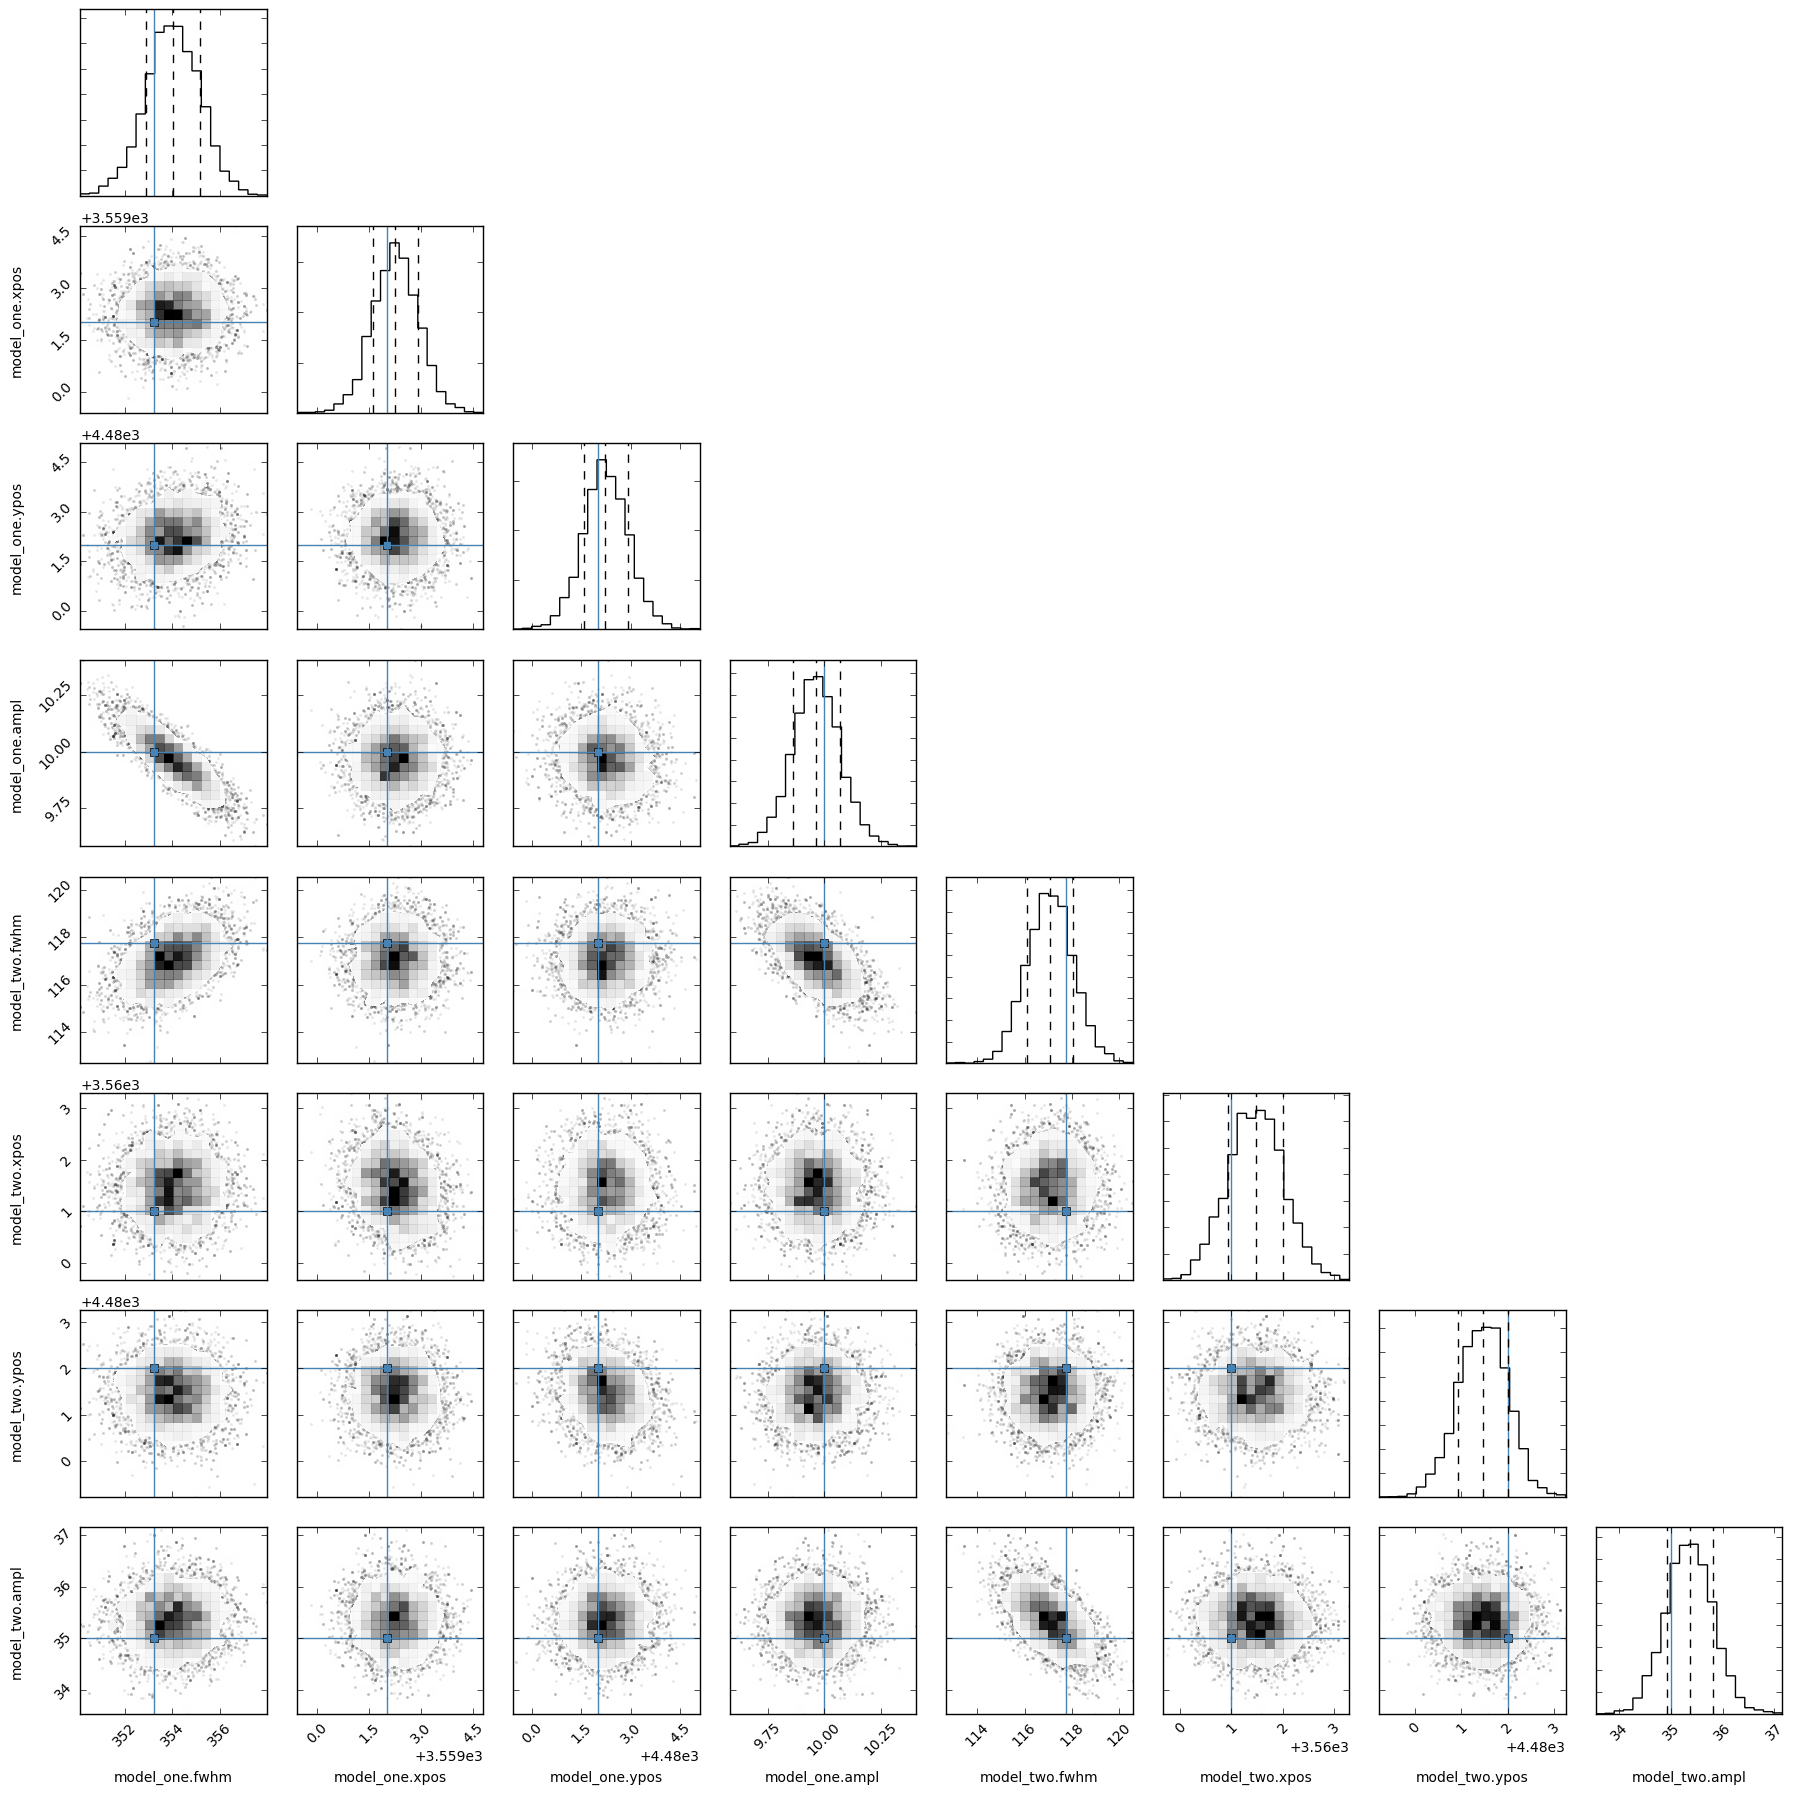

In [13]:
burnin = 0

_ = corner.corner(params[:,burnin:].T, labels=parnames, quantiles=[0.16, 0.5, 0.84], plot_contours=False, truths=parvals)
plt.tight_layout()